# Data engineer test project

My first Jupyter Notebook!

Rather than use the Socrata API to subset the data, which would be easy, I decided to grab the full dataset and do it myself, which was more educational.

Thanks for your consideration!

-ck

## Imports and config

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
sns.set(style="darkgrid")
dask.config.set(scheduler='multiprocessing')

pbar = ProgressBar()
pbar.register()

## Helper methods

In [4]:
# File downloader convenience
def download_file(url, local=False):
    # Use provided filename or else remote filename
    local_filename = url.split('/')[-1] if not local else local
    request = requests.get(url, stream=True)
    with open(local_filename, 'wb') as file:
        for chunk in request.iter_content(chunk_size=1024): 
            if chunk:
                file.write(chunk)
    return local_filename

## Download and clean the data

#### Get the full 311 Service Request dataset

In [5]:
nyc_311_data_filename = './data/rows.csv'
nyc_311_data_file = Path(nyc_311_data_filename)
if not nyc_311_data_file.is_file():
    nyc_311_data_url = 'https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv'
    download_file(nyc_311_data_url, nyc_311_data_filename)

#### Use dask to read the 11GB file from disk rather than memory and print head

In [6]:
dask_dataframe = dd.read_csv(nyc_311_data_filename, dtype='str', parse_dates=['Created Date'])
dask_dataframe.head(2)

[########################################] | 100% Completed | 13.8s


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,16741584,2010-05-26 19:00:00,06/04/2010 11:00:00 AM,DEP,Department of Environmental Protection,Water System,Hydrant Knocked Over/Missing (WC),NaN,10454,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.802668409181905,-73.91560887876318,"(40.802668409181905, -73.91560887876318)"
1,16741585,2010-05-26 18:58:00,05/28/2010 04:53:00 PM,DEP,Department of Environmental Protection,Water System,Hydrant Locking Device Request (Use Comments) ...,NaN,10456,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.8296557200314,-73.91728382642528,"(40.8296557200314, -73.91728382642528)"


#### Rename the columns to lowercase and remove spaces and parentheses, print column names

In [7]:
dask_dataframe.columns = [d
                          .strip()
                          .lower()
                          .replace(' ', '_')
                          .replace('(', '')
                          .replace(')', '') for d in dask_dataframe.columns]
dask_dataframe.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location'],
      dtype='object')

#### Subset the 311 dataset to year 2017 and listed columns only, outputting multiple partition files

In [32]:
data_columns = ['created_date',
                'complaint_type',
                'incident_zip',
                'borough',
               ]

data_date_mask = (dask_dataframe['created_date'] >= '2017-01-01') & (dask_dataframe['created_date'] < '2018-01-01')

data_2017_subset_filename = './data/data_2017_subset.csv'
data_2017_subset_file = Path(data_2017_subset_filename)
if not data_2017_subset_file.is_file():
    # Delete existing partition data
    for p in Path("./data").glob("output-*"):
        p.unlink()

    # Filter by date mask and output partition files with dask, including only the needed columns
    dask_dataframe.loc[data_date_mask].to_csv('data/output-*.csv', columns=data_columns, index=False)

#### Concat output-* csv files together, reindex, write subset csv

In [35]:
data_2017_subset = dd.read_csv('data/output-*.csv', usecols=data_columns, dtype=str)

data_2017_subset = data_2017_subset.compute()

# Because dask will use each partition's index, rather than an incremental one
data_2017_subset = data_2017_subset.reset_index(drop=True)

data_2017_subset.to_csv('data/data_2017_subset.csv')

[########################################] | 100% Completed | 44.4s


#### Check out the 2017 subset

In [36]:
data_2017_subset.head(5)

,created_date,complaint_type,incident_zip,borough
0,2017-01-03 08:49:00,Vacant Lot,11238,BROOKLYN
1,2017-01-03 09:12:00,Vacant Lot,11211,BROOKLYN
2,2017-03-30 07:03:00,Vacant Lot,11211,BROOKLYN
3,2017-02-21 10:49:00,Vacant Lot,10305,STATEN ISLAND
4,2017-02-06 11:47:00,Vacant Lot,11208,BROOKLYN


#### Check incident_zip for bad data

In [37]:
len(data_2017_subset[data_2017_subset.incident_zip.str.match('([^0-9])', na=False)])

17

#### Change poorly formatted incident_zip data to NaN

In [40]:
data_2017_subset['incident_zip'] = data_2017_subset.incident_zip.str.extract(r'([0-9]{5})', expand=False)

### Load the population by zipcode data

In [94]:
population_by_zip_columns = ['incident_zip',
                             'population',
                            ]
population_by_zip_filename = './data/zip_pop.csv'
population_by_zip_file = Path(population_by_zip_filename)
if not population_by_zip_file.is_file():
    population_by_zip_url = 'https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv'
    download_file(population_by_zip_url, population_by_zip_file)
    
population_by_zip = pd.read_csv(population_by_zip_filename, dtype=str)
population_by_zip.columns = population_by_zip_columns

# Make sure population is int for sorting later
population_by_zip['population'] = population_by_zip.population.astype(int)

population_by_zip.head(5)

,incident_zip,population
0,01001,16769
1,01002,29049
2,01003,10372
3,01005,5079
4,01007,14649


### Clean up Unspecified boroughs (bonus)

I grabbed a list of zips by NYC borough from [here](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php) and cleaned it up manually

#### Check the number of Unspecified borough rows

In [39]:
len(data_2017_subset[data_2017_subset.borough.str.match('(Unspecified)', na=False)])

41494

In [41]:
# Load the zip-to-borough DataFrame for unspecified boroughs cleanup
zip_borough_filename = './data/zip_borough.csv'
zip_borough = pd.read_csv(zip_borough_filename, dtype=str)

# Add the borough by zip column
data_2017_subset = data_2017_subset.merge(zip_borough, how='left', on=['incident_zip'])

# If we find an unspecified borough, update it from the zip_borough column
data_2017_subset['borough'] = data_2017_subset.apply(lambda x: x['zip_borough'] if x['borough'] == 'Unspecified' else x['borough'], axis=1)

In [38]:
len(data_2017_subset[data_2017_subset.borough.str.match('(Unspecified)', na=False)])

41494

### Get the top 10 complaint types

In [42]:
top_10_complaint_types = data_2017_subset.complaint_type.value_counts().nlargest(10)
top_10_complaint_types

Noise - Residential        230152
HEAT/HOT WATER             213521
Illegal Parking            146122
Blocked Driveway           136097
Street Condition            93265
Street Light Condition      84195
UNSANITARY CONDITION        79282
Noise - Street/Sidewalk     73085
Water System                65096
Noise                       60171
Name: complaint_type, dtype: int64

## Question 1

Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?

#### Create a new DataFrame that only includes complaints in the top 10 types

In [60]:
question_1_dataframe = data_2017_subset[data_2017_subset['complaint_type'].isin(top_10_complaint_types.index)]
len(question_1_dataframe)

1180986

#### Group by borough and complain_type

In [61]:
question_1_dataframe = question_1_dataframe.groupby(['borough', 'complaint_type'])
question_1_dataframe

#### Add counts column of each complaint_type within group

In [62]:
question_1_dataframe = question_1_dataframe.size().to_frame(name='count')
question_1_dataframe

count
borough       complaint_type                
BRONX         Blocked Driveway         24592
              HEAT/HOT WATER           68718
              Illegal Parking          16136
              Noise                     3134
              Noise - Residential      57687
              Noise - Street/Sidewalk  14028
              Street Condition         11761
              Street Light Condition   18410
              UNSANITARY CONDITION     24561
              Water System             10217
BROOKLYN      Blocked Driveway         49387
              HEAT/HOT WATER           66984
              Illegal Parking          55469
              Noise                    15421
              Noise - Residential      67663
              Noise - Street/Sidewalk  21317
              Street Condition         25432
              Street Light Condition   22458
              UNSANITARY CONDITION     26659
              Water System             19809
MANHATTAN     Blocked Driveway          3431
              HEAT/HOT WATER           46529
              Illegal Parking          19735
              Noise                    29002
              Noise - Residential      51055
              Noise - Street/Sidewalk  29157
              Street Condition         14840
              Street Light Condition   11077
              UNSANITARY CONDITION     14635
              Water System             10929
QUEENS        Blocked Driveway         54370
              HEAT/HOT WATER           29217
              Illegal Parking          46134
              Noise                    10685
              Noise - Residential      46415
              Noise - Street/Sidewalk   7532
              Street Condition         30633
              Street Light Condition   24258
              UNSANITARY CONDITION     11474
              Water System             18792
STATEN ISLAND Blocked Driveway          3794
              HEAT/HOT WATER            2073
              Illegal Parking           8060
              Noise                     1926
              Noise - Residential       7037
              Noise - Street/Sidewalk    867
              Street Condition         10591
              Street Light Condition    6658
              UNSANITARY CONDITION      1953
              Water System              5349

#### Sort by count descending

In [63]:
question_1_dataframe_sorted = question_1_dataframe.reset_index().sort_values(['borough','count'], ascending=False).set_index(['borough','complaint_type'])
question_1_dataframe_sorted

count
borough       complaint_type                
STATEN ISLAND Street Condition         10591
              Illegal Parking           8060
              Noise - Residential       7037
              Street Light Condition    6658
              Water System              5349
              Blocked Driveway          3794
              HEAT/HOT WATER            2073
              UNSANITARY CONDITION      1953
              Noise                     1926
              Noise - Street/Sidewalk    867
QUEENS        Blocked Driveway         54370
              Noise - Residential      46415
              Illegal Parking          46134
              Street Condition         30633
              HEAT/HOT WATER           29217
              Street Light Condition   24258
              Water System             18792
              UNSANITARY CONDITION     11474
              Noise                    10685
              Noise - Street/Sidewalk   7532
MANHATTAN     Noise - Residential      51055
              HEAT/HOT WATER           46529
              Noise - Street/Sidewalk  29157
              Noise                    29002
              Illegal Parking          19735
              Street Condition         14840
              UNSANITARY CONDITION     14635
              Street Light Condition   11077
              Water System             10929
              Blocked Driveway          3431
BROOKLYN      Noise - Residential      67663
              HEAT/HOT WATER           66984
              Illegal Parking          55469
              Blocked Driveway         49387
              UNSANITARY CONDITION     26659
              Street Condition         25432
              Street Light Condition   22458
              Noise - Street/Sidewalk  21317
              Water System             19809
              Noise                    15421
BRONX         HEAT/HOT WATER           68718
              Noise - Residential      57687
              Blocked Driveway         24592
              UNSANITARY CONDITION     24561
              Street Light Condition   18410
              Illegal Parking          16136
              Noise - Street/Sidewalk  14028
              Street Condition         11761
              Water System             10217
              Noise                     3134

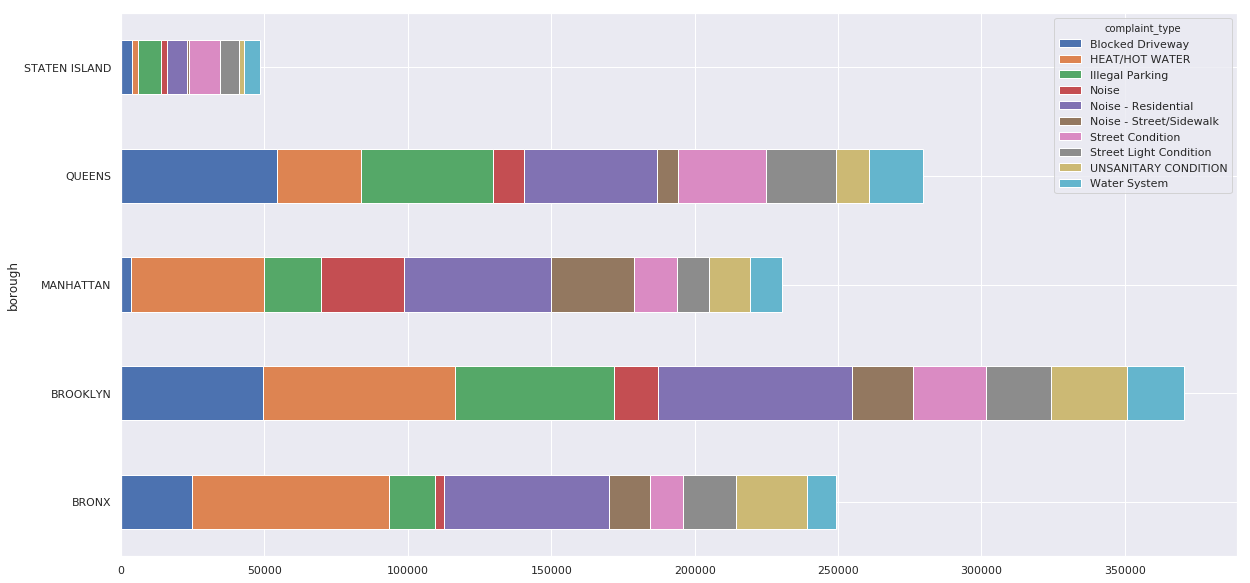

In [64]:
question_1_dataframe_sorted.pivot_table(index='borough',
                                 columns='complaint_type',
                                 values='count'
                                ).plot(kind='barh',
                                       stacked=True,
                                       figsize=(20,10)
                                      )

## Question 2

Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?

In [111]:
question_2_dataframe = data_2017_subset[data_2017_subset['complaint_type'].isin(top_10_complaint_types.index)]
question_2_dataframe.head(2)

,created_date,complaint_type,incident_zip,borough,zip_borough
5,2017-01-01 00:31:58,Noise - Residential,11373,QUEENS,QUEENS
6,2017-01-01 01:43:31,Noise - Residential,11203,BROOKLYN,BROOKLYN


#### Merge the population by zip data

In [112]:
question_2_dataframe = question_2_dataframe.merge(population_by_zip, how='left', on=['incident_zip'])
question_2_dataframe.head(5)

,created_date,complaint_type,incident_zip,borough,zip_borough,population
0,2017-01-01 00:31:58,Noise - Residential,11373,QUEENS,QUEENS,100820.0
1,2017-01-01 01:43:31,Noise - Residential,11203,BROOKLYN,BROOKLYN,76174.0
2,2017-01-01 00:34:50,Blocked Driveway,11212,BROOKLYN,BROOKLYN,84500.0
3,2017-01-01 01:29:09,Noise - Residential,10128,MANHATTAN,MANHATTAN,60453.0
4,2017-01-01 00:12:52,Blocked Driveway,11419,QUEENS,QUEENS,47211.0


#### Make list of top 10 unique zips by population from the top complaints-limited dataframe

In [113]:
top_10_zipcodes_by_population_columns = ['incident_zip', 'population']
top_10_zipcodes_by_population = question_2_dataframe[top_10_zipcodes_by_population_columns].\
    drop_duplicates().\
    nlargest(10, 'population')['incident_zip'].values

top_10_zipcodes_by_population

array(['11368', '11226', '11373', '11220', '11385', '10467', '10025',
       '11208', '11236', '11207'], dtype=object)

#### Make a new dataframe that is only complaint rows in the top 10 zips by population

In [114]:
question_2_dataframe_in_top_zips = question_2_dataframe[question_2_dataframe['incident_zip'].isin(top_10_zipcodes_by_population)]

#### Group dataframe by zip and complaint type

In [115]:
question_2_dataframe_in_top_zips = question_2_dataframe_in_top_zips.groupby(['incident_zip', 'complaint_type'])

#### Add counts column of each complaint_type within group

In [116]:
question_2_dataframe_in_top_zips = question_2_dataframe_in_top_zips.size().to_frame(name='count')

#### Sort and clean up

In [117]:
question_2_dataframe_in_top_zips.\
    reset_index().\
    sort_values(['incident_zip','count'], ascending=False).\
    set_index(['incident_zip','complaint_type'])

count
incident_zip complaint_type                
11385        Illegal Parking           4135
             Blocked Driveway          3042
             Noise - Residential       2609
             HEAT/HOT WATER            1526
             Water System              1240
             Street Condition          1232
             Street Light Condition     791
             UNSANITARY CONDITION       647
             Noise - Street/Sidewalk    607
             Noise                      507
11373        HEAT/HOT WATER            3408
             Blocked Driveway          2635
             Noise - Residential       1842
             Illegal Parking           1277
             UNSANITARY CONDITION       756
             Street Condition           691
             Water System               372
             Street Light Condition     362
             Noise - Street/Sidewalk    304
             Noise                      270
11368        Blocked Driveway          4384
             Noise - Residential       2460
             HEAT/HOT WATER            1620
             Illegal Parking           1251
             Noise - Street/Sidewalk    684
             UNSANITARY CONDITION       639
             Water System               617
             Street Condition           561
             Street Light Condition     444
             Noise                      158
...                                     ...
11207        Noise - Residential       3061
             HEAT/HOT WATER            2461
             Blocked Driveway          2062
             UNSANITARY CONDITION      1621
             Illegal Parking           1500
             Street Condition          1142
             Street Light Condition     932
             Water System               757
             Noise - Street/Sidewalk    558
             Noise                      199
10467        HEAT/HOT WATER            6041
             Noise - Residential       5807
             UNSANITARY CONDITION      2192
             Blocked Driveway          2068
             Illegal Parking            986
             Noise - Street/Sidewalk    713
             Street Condition           612
             Water System               560
             Street Light Condition     407
             Noise                      285
10025        HEAT/HOT WATER            2397
             Noise - Residential       2085
             Noise                     1398
             Noise - Street/Sidewalk   1224
             Illegal Parking            736
             UNSANITARY CONDITION       714
             Street Condition           628
             Water System               481
             Blocked Driveway           125
             Street Light Condition      21

[100 rows x 1 columns]

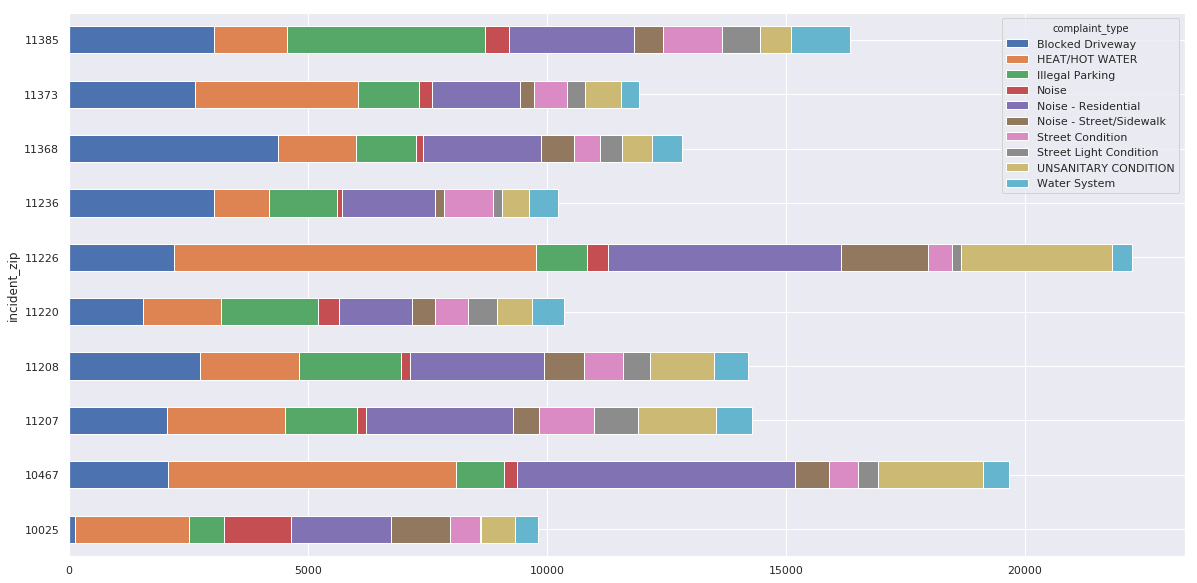

In [118]:
question_2_dataframe_in_top_zips.pivot_table(index='incident_zip',
                                             columns='complaint_type',
                                             values='count'
                                            ).plot(kind='barh',
                                                   stacked=True,
                                                   figsize=(20,10)
                                                  )

## Question 3

Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough.

In [119]:
question_3_dataframe = data_2017_subset.copy()
question_3_dataframe.head(2)

,created_date,complaint_type,incident_zip,borough,zip_borough
0,2017-01-03 08:49:00,Vacant Lot,11238,BROOKLYN,BROOKLYN
1,2017-01-03 09:12:00,Vacant Lot,11211,BROOKLYN,BROOKLYN


#### Merge in the population data

In [120]:
question_3_dataframe = question_3_dataframe.merge(population_by_zip, how='left', on=['incident_zip'])
question_3_dataframe.head(5)

,created_date,complaint_type,incident_zip,borough,zip_borough,population
0,2017-01-03 08:49:00,Vacant Lot,11238,BROOKLYN,BROOKLYN,49262.0
1,2017-01-03 09:12:00,Vacant Lot,11211,BROOKLYN,BROOKLYN,90117.0
2,2017-03-30 07:03:00,Vacant Lot,11211,BROOKLYN,BROOKLYN,90117.0
3,2017-02-21 10:49:00,Vacant Lot,10305,STATEN ISLAND,STATEN ISLAND,41749.0
4,2017-02-06 11:47:00,Vacant Lot,11208,BROOKLYN,BROOKLYN,94469.0


#### Get the borough populations by summing the unique zipcodes in each

In [122]:
borough_population = question_3_dataframe.\
    drop_duplicates(['borough', 'incident_zip', 'population']).\
    groupby('borough')['population'].\
    agg('sum')
borough_population

borough
BRONX            1592084.0
BROOKLYN         2732303.0
MANHATTAN        2087816.0
QUEENS           2755424.0
STATEN ISLAND     468730.0
Name: population, dtype: float64

#### Get the complaints per borough

In [133]:
borough_complaints = question_3_dataframe.\
    groupby('borough')['created_date'].\
    count()
borough_complaints

borough
BRONX            449154
BROOKLYN         761300
MANHATTAN        480555
QUEENS           587245
STATEN ISLAND    129059
Name: created_date, dtype: int64

#### Create a new per capita complaint column, and sort by it
#### Giving the biggest complainer borough award to the Bronx

In [134]:
borough_population_complaints = pd.concat([borough_population, borough_complaints], axis=1)
borough_population_complaints.columns = ['population', 'complaints']
borough_population_complaints['per_cap_complaints'] = borough_population_complaints['complaints'] / borough_population_complaints['population']
borough_population_complaints.sort_values(by='per_cap_complaints', ascending=False)

,population,complaints,per_cap_complaints
borough,,,
BRONX,1592084.0,449154,0.282117
BROOKLYN,2732303.0,761300,0.278629
STATEN ISLAND,468730.0,129059,0.275338
MANHATTAN,2087816.0,480555,0.230171
QUEENS,2755424.0,587245,0.213123
